In [1]:
from pandas import read_csv
from datetime import datetime
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import pandas as pd
import collections
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import pickle
from keras import backend as K


Using TensorFlow backend.


In [2]:
# load data

currencies = ['EURAUD', 'EURCAD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURUSD']


def builData(currencies):
    
    print('Loading data and parsing date')
    
    def parse(x):
        return datetime.strptime(x, '%Y-%m-%d')
    
    DF = pd.DataFrame()
    
    for curr in currencies:

        df = read_csv(curr + '.csv', delimiter='\t')
        print('Data loaded succesfully ')
        print(df.head(5))
        
        print('Reading currency: ', curr)
        DF[curr] = df['<CLOSE>']

        # dataset.index.name = 'date'

        # dataset.drop('Unnamed: 0', axis=1, inplace=True)

        # mark all NA values with 0

    DF.info()
    print(DF.head(5))

    return DF

In [13]:
curr_key = ['USD']
df = builData(currencies)
df.to_pickle('EUR')

Loading data and parsing date
Data loaded succesfully 
       <DATE>    <TIME>   <OPEN>   <HIGH>    <LOW>  <CLOSE>  <TICKVOL>  \
0  2017.01.02  00:00:00  1.45450  1.45682  1.44895  1.45587        485   
1  2017.01.02  01:00:00  1.45566  1.45990  1.45246  1.45758        591   
2  2017.01.02  02:00:00  1.45742  1.45925  1.45601  1.45755        461   
3  2017.01.02  03:00:00  1.45756  1.45864  1.45568  1.45680        372   
4  2017.01.02  04:00:00  1.45677  1.45809  1.45546  1.45624        519   

       <VOL>  <SPREAD>  
0  242500000       360  
1  295500000       437  
2  230500000       500  
3  186000000       283  
4  259000000       286  
Reading currency:  EURAUD
Data loaded succesfully 
       <DATE>    <TIME>   <OPEN>   <HIGH>    <LOW>  <CLOSE>  <TICKVOL>  \
0  2017.01.02  00:00:00  1.41036  1.41266  1.41036  1.41179        645   
1  2017.01.02  01:00:00  1.41259  1.41441  1.41199  1.41293        654   
2  2017.01.02  02:00:00  1.41293  1.41293  1.41189  1.41281        657   
3  

In [68]:
def prepareData(df):
    #creating train and test sets

    start = 24 * 30 * 18
    # df.columns.drop(['Unnamed: 0', 'date'])

    dataset = df.values

    dataset = np.array(dataset)
    dataset = dataset[-start:, :].astype(np.float64)
    print(dataset.shape)
    n_curr = len(df.columns)

    train_size = int(dataset.shape[0]*0.8)

    train = dataset[:train_size, :]
    valid = dataset[train_size:, :]
    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train)
    scaled_data_test = scaler.fit_transform(valid)

    x_train, y_train = [], []
    x_test, y_test = [], []

    lookback = 12
    for i in range(lookback,len(train)):
        x_train.append(train[i-lookback:i,:])
        y_train.append(train[i,:])
        
    for i in range(lookback,len(valid)):
        x_test.append(valid[i-lookback:i,:])
        y_test.append(valid[i,:])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], n_curr))
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], n_curr))
    
    y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1]))
    y_test = np.reshape(y_test, (y_test.shape[0],y_test.shape[1]))
    
    #indices = np.arange(x_train.shape[0])
    #np.random.shuffle(indices)

    #x_train = x_train[indices, :, :]
    #y_train = y_train[indices, :]
    

    print(x_train.shape)
    
    print(y_train.shape)
    return x_train, y_train, x_test, y_test, scaler

In [86]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def buildModel(x_train, y_train, curr_key):
    i = 0
    units = 20*6
    epoc = 3
    batch = 1
    
    for curr in curr_key:
        # create and fit the LSTM network
        model = Sequential()
        #model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(units=units))
        #model.add(Dropout(0.2))
        model.add(Dense(6))
        X = x_train[:, :, :].reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
        y = y_train[:, :]
        
        

        model.compile(loss='mean_squared_error', optimizer='Adamax')
        history = model.fit(X, y, epochs=epoc, batch_size=batch, verbose=1)
        filename = curr + '_model.sav'
        pickle.dump(model, open(filename, 'wb'))
        print('Model created :', curr)
        

        i += 1
        
        
    print('Total created models: ', i)
    return [model]
    

In [87]:
def loadModel(curr_key):
    i = 0
    models = []
    for curr in curr_key:
        # load the model from disk
        filename = curr + '_model.sav'
        loaded_model = pickle.load(open(filename, 'rb'))
        models.append(loaded_model)
        print('Loaded model: ', filename)
    return models

In [88]:
def predict(x_test, models):
    predict_arr = np.zeros((x_test.shape[0], len(models)))

    i = 0
    for model in models:
        X = x_test[:, :, :].reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
        
        prediction = model.predict(X)
        predict_arr[:, i] = prediction.reshape(prediction.shape[0], prediction.shape[1])
        i += 1
    return predict_arr

In [89]:
def getMSE(x_train, y_train, models, scaler):
    i = 0
    mse_arr = []
    ps = 0*y_train
    for model in models:
        X = x_train[:, :, :].reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
        p = model.predict(X)
        ps[:, i] = p.reshape(p.shape[0],)
        i += 1

    y_train_inv = scaler.inverse_transform(y_train)
    predict = scaler.inverse_transform(ps)
        
    for j in range(len(models)):
        mse = mean_squared_error(y_train_inv[:, j], predict[:, j])
        mse_arr.append(mse)
    return mse_arr

In [90]:
df = pd.read_pickle('EUR')
df.head(5)

,EURAUD,EURCAD,EURCHF,EURGBP,EURJPY,EURUSD
0,1.45587,1.41179,1.07122,0.85164,122.959,1.05168
1,1.45758,1.41293,1.07153,0.85188,122.856,1.05224
2,1.45755,1.41281,1.07137,0.85171,122.833,1.05193
3,1.45680,1.41212,1.07333,0.85162,122.641,1.05189
4,1.45624,1.41063,1.07265,0.85129,122.856,1.05152


In [91]:
x_train, y_train, x_test, y_test, scaler = prepareData(df)

(12960, 6)
(10356, 12, 6)
(10356, 6)


In [92]:
print(curr_key)
models = buildModel(x_train, y_train, curr_key)

['USD']
Epoch 1/3
10356/10356 [==============================] - 66s 6ms/step - loss: 68.3684
Epoch 2/3
10356/10356 [==============================] - 66s 6ms/step - loss: 0.0252
Epoch 3/3
10356/10356 [==============================] - 63s 6ms/step - loss: 0.0199
Model created : USD
Total created models:  1


In [93]:
models = loadModel(curr_key)

Loaded model:  USD_model.sav


In [94]:
predict_arr = predict(x_test, models)
horizon = 24*10

ValueError: could not broadcast input array from shape (2580,6) into shape (2580)

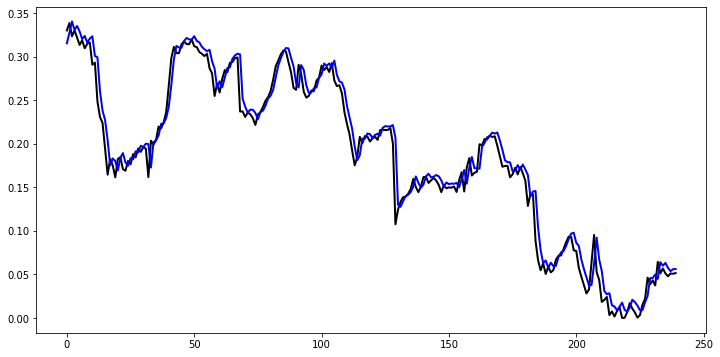

In [38]:
for i in range(len(curr_key)):
    xs = np.arange(int(horizon))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(xs, y_test[-horizon:, i], label='Real ' + curr_key[i], lw=2, color='black')
    ax.plot(xs, predict_arr[-horizon:, i], label='Forecast ' + curr_key[i], lw=2, color='blue')
    
    plt.show()

In [78]:
y_test_inv = scaler.inverse_transform(y_test)
predict = scaler.inverse_transform(predict_arr)

horizon = 24*30

ValueError: non-broadcastable output operand with shape (2580,1) doesn't match the broadcast shape (2580,6)

In [ ]:
def getActions(y, V, Cash, T):
    n = V.shape[1]
    t_cur = T
    t_prev = t_cur - 1
    t_prev2 = t_prev - 1
    t_next = t_cur + 1
    
    X_eur = Cash[t_cur, -1]
    X_new = X_eur
    A = []
    
    for c in range(n):
        action = ''
        X = 0

        d_cur = y[t_prev, c] - y[t_prev2, c]
        d_next = V[t_cur, c] - y[t_prev, c]

        if d_cur > 0 and d_next < 0:
            action = 'BUY'

        elif d_cur < 0 and d_next > 0:
            action = 'SELL'
        A.append([action, X])
    
    return A

In [ ]:
for j in range(len(curr_key)):
    mse = mean_squared_error(y_test[:, j], predict_arr[:, j])
    print(mse)

In [ ]:
V = predict[-horizon:, :]
y = y_test_inv[-horizon:, :]

n = V.shape[1]
initial_cash = 1000
X_buy = 0*V
X_sell = 0*V

Cash = np.zeros((horizon+1, n + 1))
Cash[0, -1] = initial_cash
Cash[1, -1] = initial_cash
print('n ', n)

for t in range(2, horizon):
    A = getActions(y, V, Cash, t)
    Cash[t, :] = Cash[t-1, :]
    b = 0
    c = 0
    
    print('Heure ', t)
    for a in A:        
        if a[0] == 'SELL' and Cash[t, c] > 0:
            print(str(a[0]) + ' ' + str(Cash[t, c]) + ' ' + str(curr_key[c]) + ' rate :' + str(y[t, c]))
            
            Cash[t, -1] = Cash[t, -1] + Cash[t, c]/y[t, c]
            Cash[t, c] = Cash[t, c] -  Cash[t, c]
            X_sell[t, c] = 1
            
            
            print('Euro after sell ', Cash[t, -1])
        if a[0] == 'BUY':
            b += 1
        c += 1
          
    c = 0    
    for a in A:
            
        if a[0] == 'BUY' and Cash[t, -1] > 0:
            
            print(str(a[0]) + ' ' + str(Cash[t, -1]*y[t, c]/b) + ' ' + str(curr_key[c]) + ' rate: ' + str(y[t, c]/b))
            
            Cash[t, c] = Cash[t, c] + Cash[t, -1]*y[t, c]/b
            Cash[t, -1] = Cash[t, -1] - Cash[t, -1]/b
            
            print('Euro after buy ', Cash[t, -1])
            X_buy[t, c] = 1
        
        c += 1
    
    print('Actions end of hour: ', A)
    print('Accounts status: ', Cash[t, :])
    last_day = t

final_cash = Cash[last_day, -1]
print(final_cash)
for i in range(n):
    if y[last_day, i] != 0:
        final_cash += Cash[last_day, i]/y[last_day, i]
        initial_cash += Cash[0, i]/y[0, i]

d_growth = (final_cash/initial_cash)**(1/(horizon/24)) - 1
                 
print('Initial cash value (eur): ', initial_cash)
print('Final cash value (eur): ', final_cash)
print('Daily growth: ', d_growth, '%')
print('Win: ', final_cash - initial_cash)

In [ ]:
mse_arr = getMSE(x_train, y_train, models, scaler)
for i in range(len(curr_key)):
    xs = np.arange(int(horizon))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(xs, y_test_inv[-horizon:, i], label='Real ' + curr_key[i], lw=2, color='black')
    ax.plot(xs, predict[-horizon:, i], label='Forecast ' + curr_key[i], lw=2, color='blue')
    

    rmse = mse_arr[i]
    print('rmse: ', rmse)

    rmse_max = [float(p) + float(rmse)/2 for p in predict[:, i]]
    rmse_min = [float(p) - float(rmse)/2 for p in predict[:, i]]

    ax.fill_between(xs, rmse_max[-horizon:], rmse_min[-horizon:], color='red', alpha=0.2)
    plt.show()